##IMPACT OF COVID-19 ON ENVIRONMENT##

Covid-19 is the disease caused by SARS-CoV-2, hits the world around March 2020. It forced people to remain at there home. Everythig just stopped. There was no movement of human on the ground.This somewhere affected the environment around us. 

In this project, we analyzed the effect of traffic reduction on the emission of air pollutant gases (mainly NO2) during covid-19 using sattelite and Ground station data for London Area.



In [ ]:
# !pip install geopandas
# !pip install rasterio

In [2]:
####Import the libraries #####

import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import calendar
import warnings
import geopandas as gpd
from rasterio import plot as rasterplot
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import datetime
import scipy
warnings.filterwarnings('ignore')

**ANALYSIS OF TRAFFIC DATA**

The Traffic Data has been taken from 2018 to 2021 for the London Region from Road Traffic Statitics of gov.uk site. The data shows the traffic counts of different vechile type at major and minor roads.

In [3]:
##### Plot historical value to see the changes in the traffic count over the years #########

historical_traffic_counts = pd.read_csv("/content/drive/MyDrive/BSA/Data/Traffic Data/dft_traffic_road_type_region_id_6.csv")
historical_traffic_counts['year'] = pd.to_datetime(historical_traffic_counts['year'],format='%Y')
historical_traffic_counts= historical_traffic_counts.groupby(pd.PeriodIndex(historical_traffic_counts['year'], freq="Y"))[historical_traffic_counts.columns].sum().reset_index()
historical_traffic_counts["year"] = historical_traffic_counts["year"].astype(str)
fig = px.scatter(historical_traffic_counts, x="year", y="all_motor_vehicles", 
                 trendline="lowess", trendline_options=dict(frac=0.1),
                 labels={
                     "year": "Year",
                     "all_motor_vehicles": "Vechile Count"},
                title="Total Vehicles Count 1993-2021")
fig.show()


The Yearly Historical data has been plotted to see the drop in total vechile counts. 
The graph clearly indicates that the traffic(vechile counts) has been reduced tremendously in 2020 (around 26%)

In [4]:
##### Reading Raw Count Data for Monthly and Daily Analysis  #############
traffic_count = pd.read_csv("/content/drive/MyDrive/BSA/Data/Traffic Data/dft_rawcount_region_id_6.csv", engine = 'python')
traffic_count['Date'] = pd.to_datetime(traffic_count['count_date'])
traffic_count = traffic_count.drop(traffic_count.columns[[range(0,18)]], axis=1)
traffic_count = traffic_count.drop(traffic_count.columns[[range(6,12)]], axis=1)

In [5]:
#####group by (median) month to get monthly analysis ##########
Monthly_data = traffic_count[traffic_count['Date'].dt.year >= 2018]
Monthly_data = Monthly_data.groupby(pd.PeriodIndex(Monthly_data['Date'], freq="M"))[Monthly_data.columns].median().reset_index()
Monthly_data = Monthly_data.astype({col: int for col in Monthly_data.columns[2:]})
Monthly_data = Monthly_data.set_index('Date').sort_index()
Monthly_data = Monthly_data.reindex(pd.period_range('2018-01-01','2021-12-01',freq='M').tolist()).reset_index()
Monthly_data["Date"] = pd.to_datetime(Monthly_data["Date"].astype(str))


In [6]:
monthly_desc = Monthly_data.describe()
monthly_desc = monthly_desc.drop(columns = ["link_length_miles","all_motor_vehicles"])
monthly_desc

,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,5.000000,8.031250,269.656250,6.968750,54.718750,8.812500
std,4.435924,6.684042,157.216639,5.738857,34.596508,9.233311
min,1.000000,1.000000,47.000000,0.000000,9.000000,1.000000
25%,3.000000,3.000000,167.750000,2.750000,29.750000,2.750000
50%,4.000000,5.000000,243.500000,5.500000,44.500000,5.000000
75%,5.000000,13.000000,304.750000,8.250000,70.250000,13.000000
max,21.000000,27.000000,809.000000,24.000000,174.000000,40.000000


The Monthly data statistics indicates that the **Cars and Taxis** are the prominent vechile in the London Area followed by **Large Goods Vechile**

In [7]:
###formatting data to plot vechile count based on vechile type ######

testing = pd.DataFrame()
final_df = pd.DataFrame()
for col in Monthly_data.columns: 
  if col != "Date" and col != "link_length_miles" and col != "all_motor_vehicles":
    testing['Date'] = Monthly_data["Date"]
    testing['Year'] = Monthly_data["Date"].dt.year
    testing['month'] = Monthly_data["Date"].dt.month
    testing['Vehicle Miles'] = Monthly_data['link_length_miles']
    testing['Vehicle Type'] = col
    testing["Vehicle Counts"] = Monthly_data[col]
    final_df = final_df.append(testing, ignore_index = True)
testing = None
fig = px.line(final_df, x='Date', y='Vehicle Counts', color='Vehicle Type',title= "Vehicle counts by Vehicle Type ")
fig.show()

The daily data from uk site have several gaps and can be seen in the above graph. The data present from March to November. But it clearly indicates that cars and taxis contributed most in the London Traffic as shown in above statistics. 
Due to the gaps in above data, it can't be cleary state that which month have major drop in traffic.

In [8]:
#### plot total vechile count by year ########
Monthly_sum = traffic_count.groupby(pd.PeriodIndex(traffic_count['Date'], freq="M"))[traffic_count.columns].sum().reset_index()
Monthly_sum = Monthly_sum.set_index('Date').sort_index()
Monthly_sum = Monthly_sum.reindex(pd.period_range('2018-01-01','2021-12-01',freq='M').tolist()).reset_index()
Monthly_sum["Date"] = pd.to_datetime(Monthly_sum["Date"].astype(str))
Monthly_sum["Month"] = Monthly_sum["Date"].dt.month
Monthly_sum['Month'] = Monthly_sum['Month'].apply(lambda x: calendar.month_abbr[x])
marker_req=dict(symbol="hexagon-open-dot",size=10)
fig = go.Figure()
years = [2018,2019,2020,2021]
for year in years:
  year_df = Monthly_sum[Monthly_sum["Date"].dt.year == year]
  fig.add_trace(go.Scatter(x=year_df['Month'], y=year_df['all_motor_vehicles'],
                    mode='lines+markers',marker = marker_req,name=year))
  
fig.update_layout(
    autosize = False,
    width = 900,
    height = 500,
    title="Comparision Of Total Vehicle Counts 2018-2021",
    xaxis_title="Months",
    yaxis_title="Vehicle Counts",
    legend_title=" Year ",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="RebeccaPurple"
    )
)

fig.show()

The Year wise comparision of Monthly traffic data shows a significant drop from **1st April to May (1st Lockdown Phase)**, which then significantly **increased in June** (reopening after 1st lockdown) and then further **drop in September and October** with minor lockdown phases.

In [9]:
######plotting the total miles travelled over the years (2018 - 2021)
total_miles= traffic_count.groupby(pd.PeriodIndex(traffic_count['Date'], freq="Y"))[traffic_count.columns].sum().reset_index()
total_miles["Date"] = pd.to_datetime(total_miles["Date"].astype(str))
total_miles = total_miles.astype({col: int for col in total_miles.columns[2:]})
pie_chart = total_miles[total_miles["Date"].dt.year >= 2018]
irises_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)','rgb(151, 179, 100)',
                 'rgb(175, 49, 35)', 'rgb(36, 73, 147)']
year = pie_chart["Date"].dt.year.tolist()
values = pie_chart['link_length_miles'].tolist()
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
fig.append_trace(go.Pie(labels=pie_chart["Date"].dt.year, values=pie_chart['link_length_miles'], hole=.5,marker_colors=irises_colors), row=1, col=1)
fig.append_trace(go.Bar(x=year, y=values,marker_color=irises_colors,showlegend=False),row=1, col=2)
fig.update_layout(title_text="Vehicle Miles 2018-2021",title_x=0.4)
fig.show()

The above plots shows that the total covered miles in 2020 is around 20% where as the other years have 5-7% more than it.

From the above analysis of Traffic data it can clearly says that Traffic has been reduced significantly in 2020 and more specifically during March to May


**ANALYSIS OF POLLUTANT DATA**

The Pollution data has been used from Sentinel5p satellite. The NO2 , Co and AAI Index has been Analyzed and correlated with ground station data of same gases.


In [10]:
def plot_data(rast_path,shp_path,row,col,cmap,title):
  fig, ax = plt.subplots(row,col,figsize=(16, 9), sharex=True, sharey=True)
  for i in range(len(rast_path)):
    year = os.path.basename(rast_path[i]).split("_")[-1].split(".")[0]
    shapefile = gpd.read_file(shp_path)
    raster = rasterio.open(rast_path[i])
    raster_extent = [raster.bounds[0], raster.bounds[2], raster.bounds[1], raster.bounds[3]]
    image = rasterplot.show(raster.read(1),extent=raster_extent,ax=ax[i],cmap=cmap,vmin=0.00003,vmax=0.00014)
    im = image.get_images()[0]
    shapefile.plot(ax=ax[i], edgecolor="black", facecolor="none")
    fig.colorbar(im,ax=ax[i], fraction=0.046, pad=0.04)
    ax[i].grid(which='major', color='g', linestyle='--', linewidth=0.2)
    ax[i].ticklabel_format(scilimits=(-10,10))
    ax[i].set_title(year, fontsize=16)
    ax[i].set_xlabel("Longitude")
    ax[i].legend(title= year)
    #fig.tight_layout()
    #plt.savefig('test.jpg')
  fig.suptitle(title,fontsize=16)
  fig.tight_layout()
  fig.subplots_adjust(top=1.4)

  plt.show()

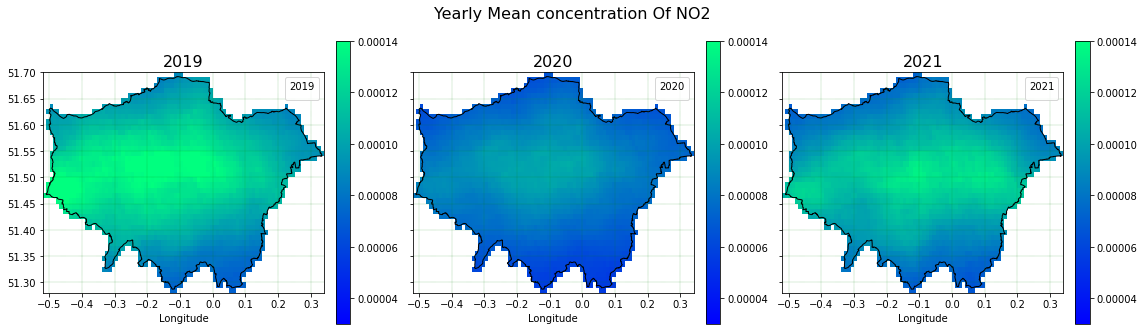

In [12]:
rast_path = glob.glob("/content/drive/MyDrive/BSA/Data/Pollutant/data_no2/*_20*.tif")
rast_path.sort()
shp_path = "/content/drive/MyDrive/BSA/Data/London_area.shp"
plot_data(rast_path,shp_path,1,3,"winter","Yearly Mean concentration Of NO2")

The above plot shows the Yearly mean Concentration of No2 in 2019, 2020 and 2021. The Map clearly shows that there is drop in No2 values in 2020. The center region shows decrease in values rather than outer area.

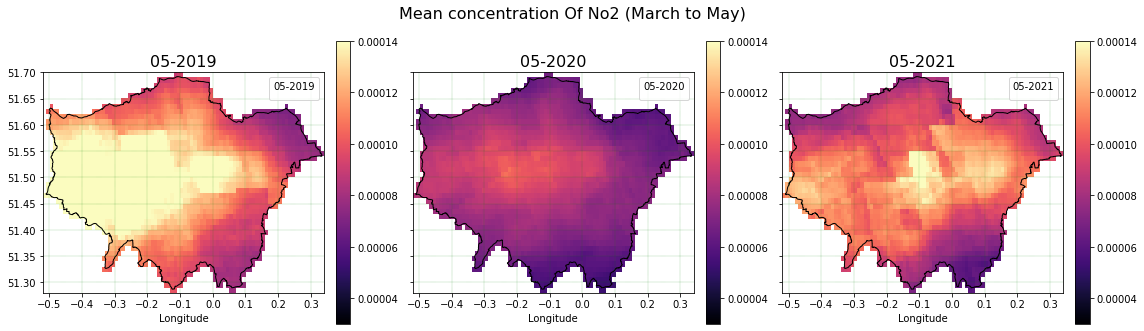

In [13]:
rast_covid_path = glob.glob("/content/drive/MyDrive/BSA/Data/Pollutant/data_no2/*05*.tif")
rast_covid_path.sort()
shp_path = "/content/drive/MyDrive/BSA/Data/London_area.shp"
plot_data(rast_covid_path,shp_path,1,3,"magma","Mean concentration Of No2 (March to May)")

The above plots compare the Lockdown phase in 2020 with the same time period in 2019 and 2021. The 2019 image shows significantly higher values in the western side whereas it seems calmer in 2020 and then little increase in 2021 though less with respect to 2019.

In [14]:
def plot_mon_data(rast_path,shp_path,row,col):
  k = 0
  fig, ax = plt.subplots(row,col,figsize=(16, 9), sharex=True, sharey=True)
  for i in range(row):
    for j in range(col):
      year = os.path.basename(rast_path[k]).split("_")[-1].split(".")[0]
      shapefile = gpd.read_file(shp_path)
      raster = rasterio.open(rast_path[k])
      raster_extent = [raster.bounds[0], raster.bounds[2], raster.bounds[1], raster.bounds[3]]
      image = rasterplot.show(raster.read(1),extent=raster_extent,ax=ax[i][j],cmap='winter',vmin=0.00003,vmax=0.00012)
      im = image.get_images()[0]
      shapefile.plot(ax=ax[i][j], edgecolor="black", facecolor="none")
      fig.colorbar(im,ax=ax[i][j], fraction=0.046, pad=0.04)
      ax[i][j].grid(which='major', color='g', linestyle='--', linewidth=0.2)
      ax[i][j].ticklabel_format(scilimits=(-10,10))
      ax[i][j].set_title(year, fontsize=16)
      ax[i][j].set_xlabel("Longitude")
      #ax[i][j].legend(title= year)
      k = k+1
    #plt.savefig('test.jpg')
  fig.suptitle("NO2 mean Concentration in 2020",fontsize=16)
  fig.tight_layout()
  fig.subplots_adjust(top=0.88)
  plt.show()

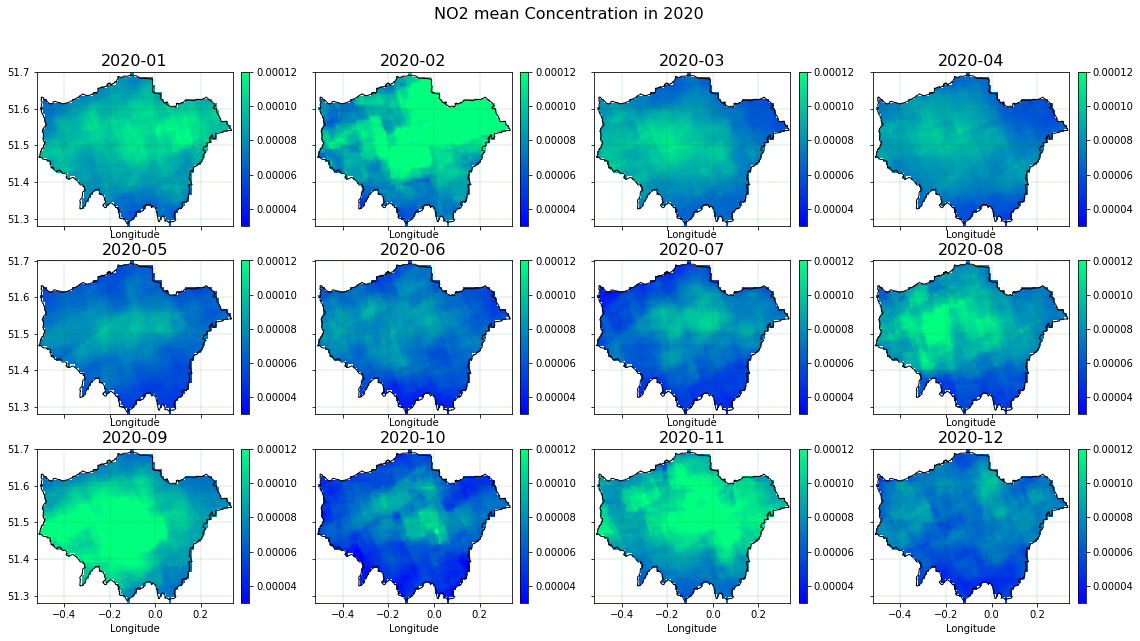

In [15]:
monthly_mean_img = glob.glob("/content/drive/MyDrive/BSA/Data/Pollutant/data_no2/Monthly_mean/*.tif")
monthly_mean_img.sort()
plot_mon_data(monthly_mean_img,shp_path,3,4)


The Above graphs shows the mean monthly condition of NO2 in london during 2020. The pattern of Images clearly indicates the drop of NO2 in lockdown phases rather than opening phase.

The daily mean value of NO2(Tropospheric), CO and Absorbing Aerosol Index has been extracted to see further statistical Analysis.

In [16]:
###Reading pollutant data###
data_NO2 = pd.read_csv("/content/drive/MyDrive/BSA/Data/Pollutant/data_no2/NO2_mean_data_new.csv")
data_CO = pd.read_csv("/content/drive/MyDrive/BSA/Data/Pollutant/data_no2/CO_mean_data.csv")
data_AAI = pd.read_csv("/content/drive/MyDrive/BSA/Data/Pollutant/data_no2/AAI_mean_data.csv")

In [17]:
def format_df(dataframe):
  dataframe = dataframe.groupby(pd.PeriodIndex(dataframe['Date'], freq='M'))[dataframe.columns].mean().reset_index()
  dataframe['Date'] = dataframe['Date'].astype(str)
  if dataframe.columns[1] != "Absorbing_Aerosol_Index_Mean":
    dataframe['Pollutant'] = dataframe.columns[1] + " (mol^m2)" 
  else:
    dataframe['Pollutant'] = dataframe.columns[1]
  dataframe = dataframe.rename(columns = {dataframe.columns[1]:'Values'})
  return dataframe

In [18]:
import numpy as np
fig = make_subplots(rows=3, cols=1)
dfs = [data_NO2,data_CO,data_AAI]
i = 0
for data in dfs:
  data = format_df(data)
  fig.add_trace(
    go.Scatter(x= data[data.columns[0]], y= data[data.columns[1]],name = data.iloc[0]['Pollutant']),
    row=i+1, col=1)
  fig.add_vrect(x0='2020-04', x1='2020-06', 
              annotation_text="1st", annotation_position="top left",
              annotation=dict(font_size=10, font_family="Times New Roman"),
              fillcolor="pink", opacity=0.25, line_width=0)
  fig.update_yaxes(minexponent=10)
  i = i+1
fig.update_layout(height=800, width=1000, title_text="Monthly Mean Pollutant over 2019 - 2021")

fig.show()

The above plot shows the time series of mean monthly value of NO2,Co and AAI with 1st lockdown Phase. The Tropospheric NO2 shows a decline during lockdown phases but CO and AAI shows a both drop and increase.

**The Ground station data has been extracted from AURN Monitoring station of London**.

To see whether the satellite data implying the correct condition of pollutant on the ground, we correlated the ground NO2 data with the satellite extarcted one

In [19]:
def clean_df(CSV_data,gas):
  #CSV_data = Co_path
  CSV_data.sort()
  all_data = pd.DataFrame()
  for data in CSV_data:
    ground_d = pd.read_csv(data)
    for i in range(1,int(len(ground_d))):
      try:
        ground_d = ground_d.drop(columns=["Status/units."+str(i)])
      except:
        continue
    #ground_co = ground_co.drop(columns =["Status/units"] )
    ground_d.drop(ground_d.tail(2).index,inplace=True) 
    ground_d_avg = pd.DataFrame()
    ground_d_avg["Date"] = pd.to_datetime(ground_d["End Date"])
    ground_d_avg[gas] = ground_d.iloc[:, 2:len(ground_d.columns)+1].mean(axis = 1)
    all_data = all_data.append(ground_d_avg)
  all_data = all_data.groupby(pd.PeriodIndex(all_data['Date'], freq='d'))[all_data.columns].mean().reset_index()
  all_data = all_data.set_index('Date').sort_index()
  all_data = all_data.reindex(pd.period_range('2019-01-01','2021-12-31',freq='d').tolist()).reset_index()
  all_data['Date'] = all_data['Date'].astype(str)
  return all_data

In [32]:
Co_path = glob.glob("/content/drive/MyDrive/BSA/Data/Pollutant/*CO.csv")
No_path = glob.glob("/content/drive/MyDrive/BSA/Data/Pollutant/*NO2.csv")
ground_co_data = clean_df(Co_path,"CO_ground")
ground_no_data = clean_df(No_path,"NO2_ground")

In [33]:
fig = px.line(ground_no_data, x='Date', y='NO2_ground', title= "Avg daily concentration of NO2")
fig.show()


In [34]:
import scipy
def corr(df,x,y):
  df = df.dropna()
  x = df[x]
  y= df[y]
  pearsonr_corr = scipy.stats.pearsonr(x, y)
  spearmanr_corr = scipy.stats.spearmanr(x, y)
  kendalltau_corr = scipy.stats.kendalltau(x, y)
  print("pearsonrResult",pearsonr_corr)
  print(spearmanr_corr)
  print(kendalltau_corr)

In [35]:
data_NO2["Date"] = pd.to_datetime(data_NO2["Date"].astype('datetime64[ns]'))
data_CO["Date"] = pd.to_datetime(data_CO["Date"].astype('datetime64[ns]'))
ground_no_data['Date'] = pd.to_datetime(ground_no_data['Date'].astype('datetime64[ns]'))
ground_co_data['Date'] = pd.to_datetime(ground_co_data['Date'].astype('datetime64[ns]'))
com_NO2 = pd.merge(data_NO2, ground_no_data, on=['Date'])
com_CO = pd.merge(data_CO, ground_co_data, on=['Date'])
corr(com_NO2,"NO2_ground","NO2_Mean")

pearsonrResult (0.7057911310836081, 1.9262567735179134e-100)
SpearmanrResult(correlation=0.6432828635666613, pvalue=3.0449902320684413e-78)
KendalltauResult(correlation=0.46065517369129366, pvalue=5.2989782624729683e-70)


The above correlation shows moderate positive relationship between ground station and satellite NO2 data. 

In [36]:
mon_data = pd.DataFrame()
test_no = ground_no_data
test_no = test_no.groupby(pd.PeriodIndex(test_no['Date'], freq='M'))[test_no.columns].mean().reset_index()
mon_data['Month'] = test_no[test_no['Date'].dt.year == 2019]['Date'].dt.month.apply(lambda x: calendar.month_abbr[x])
year = ['2019','2020','2021']
for y in year:
  mon_data[y] = ground_no_data[ground_no_data['Date'].dt.year == int(y)].reset_index().iloc[:,2]

# mon_data['Reduction_2019_2020'] =  ((mon_data['2020'] - mon_data['2019'])/mon_data['2019'])*100
# mon_data['Reduction_2020_2021'] =  ((mon_data['2021'] - mon_data['2020'])/mon_data['2020'])*100
mon_data.describe()

,2019,2020,2021
count,12.000000,12.000000,12.000000
mean,30.333578,23.538919,24.539177
std,9.323324,10.677489,5.233088
min,15.948803,10.535191,16.155501
25%,24.309771,16.395902,20.128806
50%,28.196411,19.828534,25.750128
75%,37.387168,31.519323,28.468039
max,44.409464,41.985139,31.318311


In [37]:
fig = px.line(mon_data,x='Month',y=['2019','2020','2021'],title= "Monthly Concentration Of NO2")
fig.show()

The No2 concentration unexpectedly rise in september due to opening of lockdown in June

In [38]:
year_avg = ground_no_data
year_avg = year_avg.groupby(pd.PeriodIndex(year_avg['Date'], freq='Y'))[year_avg.columns].median().reset_index()
year_avg['Date'] = year_avg['Date'].astype(str)
pie_new_chart = pie_chart[pie_chart['Date'].dt.year > 2018]

In [39]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "bar"}]],subplot_titles=('Total Miles',  'NO2 Concentration (ugm-3)'))
fig.append_trace(go.Bar(x=(pie_new_chart["Date"].dt.year).astype(str), y=pie_new_chart['link_length_miles'],marker_color=irises_colors,showlegend=False), row=1, col=1)
fig.append_trace(go.Bar(x=year_avg['Date'], y=year_avg['NO2_ground'],marker_color=irises_colors,showlegend=False),row=1, col=2)
fig.update_layout(title_text="Vehicle Miles and NO2 concentration 2018-2020",title_x=0.4)
fig.show()

**Total miles covered by vechile and NO2 concentration both droped in 2020.**